# Analysing time series economical data using RNN


# Data preprocessing

In [4]:
# import libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# read data (industrial data that measures elevant establishments located in the United States)
data = pd.read_csv('production.csv', index_col='DATE',parse_dates=True)

In [28]:
data.columns = ['Production']
data

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
1972-06-01,100.5960
1972-07-01,100.1263
1972-08-01,96.3607
1972-09-01,85.8007


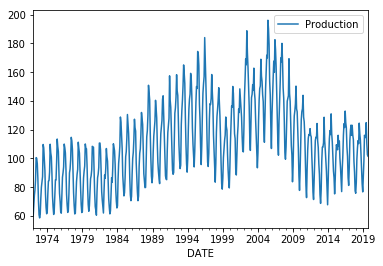

In [7]:
data.plot()

In [8]:
## train_test_split 
# note that we don't split randomly 
len(data)

573

In [9]:
length_data = 24
train_data = data[: len(data)-length_data]
test_data = data[-length_data:]

In [10]:
len(train_data)

549

In [11]:
len(test_data)

24

In [13]:
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
train_scaled_data = scaler.transform(train_data)
test_scaled_data = scaler.transform(test_data)

In [14]:
# create the time series generator 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
batch_size = 1
length=23
generator = TimeseriesGenerator(train_scaled_data, train_scaled_data, length=length, batch_size=batch_size)

In [1]:
x,y = generator[0]

In [2]:
y

# Create the Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense 

In [18]:
num_features = 1 
length= 23
model = Sequential()
model.add(LSTM(200, input_shape = (length, num_features))) # 200 neurons
model.add(Dense(1)) # we need to predict only the next value 

model.compile(optimizer='adam', loss='mse') # mse for continuous data 
model.summary()

In [172]:
# create an earlystop and validation generator to start training
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)
val_generator = TimeseriesGenerator(test_scaled_data, test_scaled_data, length=length, batch_size=batch_size)

In [19]:
model.fit_generator(generator, epochs=10, validation_data = val_generator, callbacks=[early_stop])

In [175]:
loss = pd.DataFrame(model.history.history)

In [20]:
loss.head()

In [21]:
loss.plot()

# Model evaluation

In [150]:
# Forecast using the last 18 months from the dataset
predictions = []

first_eval_batch = train_scaled_data[-length:]
current_batch = first_eval_batch.reshape((1, length, num_features))

for i in range(len(test_data)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [22]:
predictions_inverse_scaled = scaler.inverse_transform(predictions)
test_data['predictions'] = predictions_inverse_scaled

In [23]:
test_data

In [24]:
test_data.plot()

# Forecast new data


In [174]:
full_scaler = MinMaxScaler()
data_scaled = full_scaler.fit_transform(data) # scale the whole dataset


In [ ]:
length = 18 # Length of the output sequences 
generator = TimeseriesGenerator(data_scaled, data_scaled, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(200, activation='tanh', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

In [ ]:
# create for loop to predict the values of each of the following 18 months 
forecast = []
periods = 18

first_eval_batch = data_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast) # inverse the scaled data

In [ ]:
index = pd.date_range(start='2019-10-01',periods=periods,freq='MS') # create a time stamp for the new predictions
forecast_df = pd.DataFrame(data=forecast,index=index,columns=['Forecast'])# create a dataframe of the predictions

In [ ]:
# plot the predictions and the original dataset
ax = data.plot()
forecast_df.plot(ax=ax)